# Georgia Absentee Ballot Data Analysis
### Exploratory Analysis of Rejected Absentee Ballots and Applications for the 2020 and 2022 Georgia General Election

The Georgia Secretary of State uploads updated Absentee Files to https://sos.ga.gov/page/voter-absentee-files for public use. 

I was not able to webscrape this data, so I manually downloaded the “STATEWIDE” level data for the “11/03/2020- GENERAL/SPECIAL ELECTION” and “11/08/2022 - GENERAL/SPECIAL ELECTION” to conduct my research. You can find these downloaded datasets in this dropbox folder: https://uchicago.box.com/s/aqgtlbtkkb2bh34saaw5d5z4fam41vvf 


Voter suppression has been on the rise over the past decade, specifically attacking Absentee Voting. Georgia has been central in the fight againsst voter suppression. In this exploratory research project, I aimed to analyze Absentee Application and Ballot Rejections from the past two General Elections. I last downloaded the 2022 data on 11/13, but since then the numbers have been updated and the election results resulted in a runoff. 

## Where did the most ballot and application rejections happen?

The code below creates four different Chloropleths of Georgia illustrating the counties with a color differentiation based on the number of rejections. Most counties had less than 1000 rejections, but the major ones were easily highlighted on the Chloropleths.

In [78]:
import pandas as pd
import os
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
path ='/Users/shanelsingh/Documents/Documents - Shanel’s MacBook Pro/GitHub/Data and Programming Final Project/'
os.chdir(path)

# Get GEORGIA 2020 and 2022 Absentee Data 
GA_2020 = pd.read_csv(os.path.join(path,'GEORGIA AB DATA/2020 STATEWIDE AB Data.csv'), encoding='latin-1')
GA_2022 = pd.read_csv(os.path.join(path,'GEORGIA AB DATA/2022 STATEWIDE AB Data.csv'), encoding='latin-1')

/Users/shanelsingh/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (6,12,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [80]:
def get_clean_data(df): 
    df_columns = df[['County','Voter Registration #','City','Mailing Zip Code', 'Application Status','Ballot Status', 'Status Reason',]]
    df_ab_apps = df_columns[(df_columns['Ballot Status'] != "A") | (df_columns['Application Status'] != "A")]
    return (df_ab_apps)
    
GA_2020_rejected = get_clean_data(GA_2020)
GA_2022_rejected = get_clean_data(GA_2022)

def get_rejected_counts(df):
    df_reject_apps = df[df['Application Status'] == "R"]
    df_apps_groupby_county = df_reject_apps.groupby('County').count()
    df_apps_by_county = df_apps_groupby_county['Application Status']
    df_reject_ab = df[df['Ballot Status'] == "R"]
    df_ab_groupby_county = df_reject_ab.groupby('County').count()
    df_ab_by_county = df_ab_groupby_county['Ballot Status']
    df_rejected_counts = pd.concat([df_ab_by_county,df_apps_by_county], axis=1)
    df_rejected_counts = df_rejected_counts.reset_index()
    df_rejected_counts = df_rejected_counts.fillna(0)
    return (df_rejected_counts)

GA_2020_rejected_counts = get_rejected_counts(GA_2020_rejected)
GA_2022_rejected_counts = get_rejected_counts(GA_2022_rejected)

In [81]:
GA_rejected_counts = pd.merge(GA_2022_rejected_counts, GA_2020_rejected_counts, how='outer', on='County')
GA_rejected_counts = GA_rejected_counts.fillna(0)
GA_rejected_counts.columns
GA_rejected_counts = GA_rejected_counts.rename(columns={'Application Status_x': '2022 Applications Rejected',
                                                        'Ballot Status_x': '2022 Ballots Rejected',
                                                        'Application Status_y': '2020 Applications Rejected', 
                                                        'Ballot Status_y': '2020 Ballots Rejected'})

**GEORGIA COUNTY SHAPE FILES** https://arc-garc.opendata.arcgis.com/datasets/dc20713282734a73abe990995de40497/explore?location=32.608435%2C-81.663229%2C6.85


In [82]:
path = '/Users/shanelsingh/Documents/Documents - Shanel’s MacBook Pro/GitHub/final-project-ga-ab-analysis/'
os.chdir(path)
GA_counties = geopandas.read_file(os.path.join(path,'Counties_Georgia/Counties_Georgia.shp'))
GA_counties = GA_counties[['COUNTYFP10','NAMELSAD10', 'totpop10','Label','geometry']]
GA_data = pd.merge(GA_counties, GA_rejected_counts, how='outer', left_on='Label', right_on='County')
GA_data = GA_data.drop('County',axis=1)
GA_data = GA_data.fillna(0)
GA_data = GA_data.rename(columns={'NAMELSAD10':'County Name'})

In [83]:
import bokeh
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from ipywidgets import interact, interact_manual

import csv
import numpy as np

In [84]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [85]:
ab_years = ['2020 Ballots Rejected','2022 Ballots Rejected'] 
app_years = ['2020 Applications Rejected','2022 Applications Rejected']

@interact_manual(ab_year=ab_years, app_year=app_years)
def plot_county_ballot_data(ab_year=ab_years, app_year=app_years):
    fig, axs = plt.subplots(1,2, figsize=(15,15)) 
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(axs[0])
    cax=divider.append_axes('right',size ='5%',pad=0.1)
        
    axs[0] =  GA_data.plot(ax=axs[0], column=GA_data[ab_year], edgecolor='grey', legend=True, cax=cax, cmap='Greens')
    axs[0].axis('off')
    axs[0].set_title('GA '+ ab_year);
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(axs[1])
    cax=divider.append_axes('right',size ='5%',pad=0.1)
        
    axs[1] =  GA_data.plot(ax=axs[1], column=GA_data[app_year], edgecolor='grey', legend=True, cax=cax, cmap='Greens')
    axs[1].axis('off')
    axs[1].set_title('GA '+ app_year);
    return

interactive(children=(Dropdown(description='ab_year', options=('2020 Ballots Rejected', '2022 Ballots Rejected…

## Is there a relationship between ballot rejections and county demographics?

To study the relationship between ballot and applicatoin rejections and demographics, I ran OLS regressions on different Census demographic data. To collect the data, I web scraped Georgia county level data from the Census from the 2021 American Community Survey. I regressed the number of individuals commuting to work on public transportation, median household income, and employment status (civilian workforce) on the two variables. 

In [86]:
#Get Census Data 
import requests
api_key = '34c857903965a90eca2ae56cb47efed22f82d774'
url = 'https://api.census.gov/data/2021/acs/acs1/profile?get=group(DP03)&for=county:*&in=state:13&key=34c857903965a90eca2ae56cb47efed22f82d774'
response = requests.request('GET',url)

def json_to_dataframe(response):
    return pd.DataFrame(response.json()[1:], columns=response.json()[0])

census_df = json_to_dataframe(response) #census American Community Survey Data Profiles 
census_df = census_df[['NAME','DP03_0008E','DP03_0021E', 'DP03_0062E']]  

#Webscraped Census Data on the county level for Georgia
census_df[['County','x','y']] = census_df['NAME'].str.split(pat=" ", expand=True)
census_df = census_df.drop(['x','y'], axis=1)
census_df['County'] = census_df['County'].str.upper()

#Merge with Absentee data to run regressions
GA_regression_df= pd.merge(GA_rejected_counts, census_df, how='outer', on='County')
GA_regression_df.loc[:,'DP03_0008E':'DP03_0062E'] = GA_regression_df.loc[:,'DP03_0008E':'DP03_0062E'].fillna(0)
GA_regression_df.loc[:,'DP03_0008E':'DP03_0062E'] = GA_regression_df.loc[:,'DP03_0008E':'DP03_0062E'].astype(float)

GA_reg_data = GA_regression_df.rename(columns={'DP03_0008E':'Employment status civilan workforce',
                                               'DP03_0021E':'Commuting to work public transit',
                                               'DP03_0062E':'Median household income'})


In [90]:
from sklearn import linear_model

y = GA_reg_data[['2022 Ballots Rejected', '2022 Applications Rejected',
                '2020 Ballots Rejected', '2020 Applications Rejected']]
x = GA_reg_data[['Employment status civilan workforce',
                'Commuting to work public transit', 'Median household income']]

regr = linear_model.LinearRegression()

for variable in y: 
    regr.fit(x, y)
print(regr.coef_)

[[ 6.33202081e-04 -4.13300158e-09 -3.59074080e-04]
 [ 2.22694676e-03 -3.45319651e-08 -1.75882487e-03]
 [ 1.14657061e-03  1.47347160e-08 -4.67918452e-04]
 [ 3.72564103e-03 -3.01685753e-08 -2.71354497e-03]]


## Georgia Absentee Ballot Tweets Sentiment Analysis

To contextualize the narrative around Absentee Ballots in Georgia, I used the snscrape package to web scrape tweets that were posted a month before the election that contained “Absentee”, “Ballot” and “Georgia.” I conducted a sentiment analysis of polarity and subjectivity on all the tweets pulled from 10/8 to 11/8 and visualized the findings using a histogram and Kernal Density Plot. 


In [ ]:
import snscrape.modules.twitter as sntwitter
import spacy
import re 
import nltk
nlp = spacy.load('en_core_web_sm')
from spacytextblob.spacytextblob import SpacyTextBlob
nlp.add_pipe('spacytextblob')
import matplotlib.colors as mcolors
import seaborn as sns

In [61]:
ab_query = 'Georgia absentee ballots until:2022-11-08 since:2022-10-08' #This is a month out from the 2022 General Election Day
ab_tweets = []

for tweet in sntwitter.TwitterSearchScraper(ab_query).get_items():
    ab_tweets.append([tweet.date, tweet.content])  
          
ab_tweets_df = pd.DataFrame(ab_tweets, columns=['Date','Tweet'])

In [62]:
ab_tweets_only = ab_tweets_df['Tweet'] #Extract just the tweets for sentiment analysis 

all_ab_tweets_lines= []
for word in ab_tweets_only:
    all_ab_tweets_lines.append(word)
    
docs = [(nlp(text)) for text in all_ab_tweets_lines]    #Turning lines into docs for sentiment analysis
    
ab_tweeet_polarities = []
for doc in docs:
    polarity = doc._.blob.polarity
    ab_tweeet_polarities.append(polarity) 
    
ab_tweeet_subjectivities = []
for doc in docs:
    subjectivity = doc._.blob.subjectivity
    ab_tweeet_subjectivities.append(subjectivity)    
    
ab_tweet_data = [ab_tweeet_polarities, ab_tweeet_subjectivities] #
sentiment_df = pd.DataFrame(ab_tweet_data)
sentiment_df = sentiment_df.T 
sentiment_df = sentiment_df.rename(columns={0:'AB Polarity',
                                            1:' AB Subjectivity'})

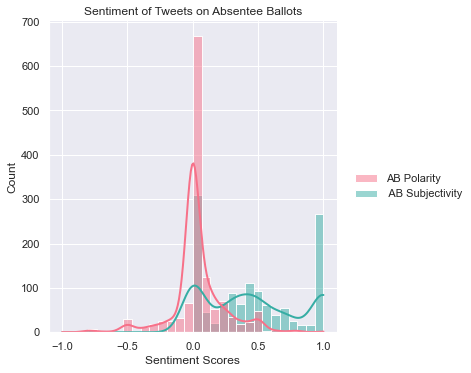

In [51]:
sns.set_theme(style="darkgrid")
sns.set_palette("husl", 2)
sns.set_context(font_scale=1.20, rc={"lines.linewidth": 2})
graph = sns.displot(sentiment_df, kde=True, fill=True).set(title='Sentiment of Tweets on Absentee Ballots')
graph.despine(offset=0, trim=False);
graph.set_xlabels('Sentiment Scores')